For this project, we need to
*   Manipulate data using Pandas and Numpy
*   Visualize data using Matplotlib.pyplot
*   Scale and evaluate using Scikit-learn
*   Model using TensorKlow

In [ ]:
#Importing the libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed

set_seed(455)
np.random.seed(455)

# Data Analysis

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset = pd.read_csv("/content/drive/MyDrive/data/Mastercard_stock_history.csv", index_col="Date", parse_dates=["Date"]).drop(["Dividends", "Stock Splits"], axis=1)
print(dataset.head())

                Open      High       Low     Close     Volume
Date                                                         
2006-05-25  3.748967  4.283869  3.739664  4.279217  395343000
2006-05-26  4.307126  4.348058  4.103398  4.179680  103044000
2006-05-30  4.183400  4.184330  3.986184  4.093164   49898000
2006-05-31  4.125723  4.219679  4.125723  4.180608   30002000
2006-06-01  4.179678  4.474572  4.176887  4.419686   62344000


As we notice at an initial glance
*   Minimum stock price = $4.10

*   Highest stock price = $400.5

This impliest that:
*   Mean = $105.9

*   SD = $107.3

We shall select High column as a model feature since it provides us info of how high the values of the share went on the given day.

Here, .describe() is used to analyze the data in depth by giving the:
  * count
  * mean
  * standard deviation
  * minimum
  * 25th percentile(quartile 1)
  * 50th percentile(median)
  * 75th percentile (quartile 3)
  * maximum value

for each column in the DataFrame. The above details are outputted as a table with one row for each column in the DataFrame.

.describe() can also be used for the same purpose in case of Serial Objects. Unlike the case of Dataframes, the output the .describe() method will be a single row.

Serial Objects are 1-dimensional arrays with an additional attribute *index*, which is used to access the values in the Series object.

In [ ]:
print(dataset.describe())

              Open         High          Low        Close        Volume
count  3872.000000  3872.000000  3872.000000  3872.000000  3.872000e+03
mean    104.896814   105.956054   103.769349   104.882714  1.232250e+07
std     106.245511   107.303589   105.050064   106.168693  1.759665e+07
min       3.748967     4.102467     3.739664     4.083861  6.411000e+05
25%      22.347203    22.637997    22.034458    22.300391  3.529475e+06
50%      70.810079    71.375896    70.224002    70.856083  5.891750e+06
75%     147.688448   148.645373   146.822013   147.688438  1.319775e+07
max     392.653890   400.521479   389.747812   394.685730  3.953430e+08


Next, we count the number of missing values in the dataframe using the .isna().sum() method.

In [ ]:
dataset.isna().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

Now consider our dataset:
*   MasterCard stock prices have been on the rise since 2016.
*   It had a dip in the first quarter of 2020 but it gained a stable position in the latter half of the year.

Our test dataset => from 2021 to 2022.

Training dataset => the rest of the data.

Next we define a train_test_plot function that takes the arguments:
*  dataset
*  tstart and tend: time limit in years

and plots a simple line graph.

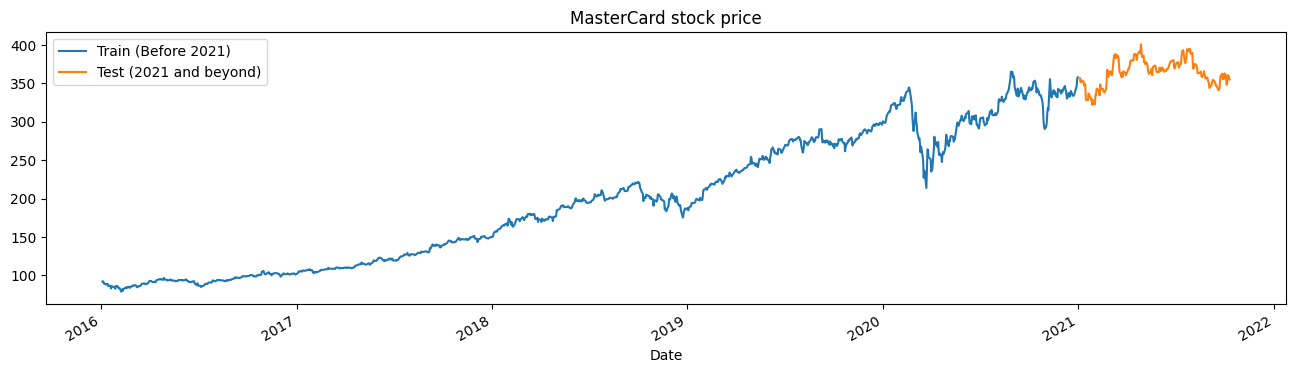

In [ ]:
tstart = 2016
tend = 2020

def train_test_plot(dataset, tstart, tend):
    dataset.loc[f"{tstart}":f"{tend}", "High"].plot(figsize=(16, 4), legend=True)
    dataset.loc[f"{tend+1}":, "High"].plot(figsize=(16, 4), legend=True)
    plt.legend([f"Train (Before {tend+1})", f"Test ({tend+1} and beyond)"])
    plt.title("MasterCard stock price")
    plt.show()

train_test_plot(dataset,tstart,tend)

# Data Preprocessing

The train_test_split function divides the dataset into two subsets: training_set and test_set.

In [ ]:
def train_test_split(dataset, tstart, tend):
    train = dataset.loc[f"{tstart}":f"{tend}", "High"].values
    test = dataset.loc[f"{tend+1}":, "High"].values
    return train, test
training_set, test_set = train_test_split(dataset, tstart, tend)

the MinMaxScaler function standardizes our training set to avoid the outliers or anomalies.

*Outliers are those data points that are significantly different from the rest of the dataset.*

*Anomaly detection is a process of finding those rare items, data points, events, or observations that make suspicions by being different from the rest data points or observations.*

In [ ]:
sc = MinMaxScaler(feature_range=(0, 1))
training_set = training_set.reshape(-1, 1)
training_set_scaled = sc.fit_transform(training_set)

The split_sequence function uses a training dataset and converts it into inputs (X_train) and outputs (y_train).

For example, if the sequence is [1,2,3,4,5,6,7,8,9,10,11,12] and the n_step is three, then it will convert the sequence into three input timestamps and one output as shown below:

![picture](https://drive.google.com/uc?export=view&id=11fj0XQQ28RihGL7KjXbZ7LM_rY5Bi1nd)

In this project, we are using 60 n_steps. We can also reduce or increase the number of steps to optimize model performance.

In [ ]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


n_steps = 60
features = 1

# split into samples
X_train, y_train = split_sequence(training_set_scaled, n_steps)

We are working with univariate series, so the number of features is one, and we need to reshape the X_train to fit on the LSTM model. The X_train has [samples, timesteps], and we will reshape it to [samples, timesteps, features].

# LSTM Model

The model consists of a single hidden layer of LSTM and an output layer. For this experiment, we will set LSTM units to 125, tanh as activation, and set input size.

Finally, we will compile the model with an RMSprop optimizer and mean square error as a loss function.

In [ ]:
# The LSTM architecture
model_lstm = Sequential()
model_lstm.add(LSTM(units=125, activation="tanh", input_shape=(n_steps, features)))
model_lstm.add(Dense(units=1))
# Compiling the model
model_lstm.compile(optimizer="RMSprop", loss="mse")

model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 125)               63500     
                                                                 
 dense (Dense)               (None, 1)                 126       
                                                                 
Total params: 63,626
Trainable params: 63,626
Non-trainable params: 0
_________________________________________________________________


The model will train on 50 epochs with 32 batch sizes. You can change the hyperparameters to reduce training time or improve the results.

In [ ]:
model_lstm.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
38/38 [==============================] - 5s 66ms/step - loss: 0.0139
Epoch 2/50
38/38 [==============================] - 4s 113ms/step - loss: 0.0033
Epoch 3/50
38/38 [==============================] - 3s 71ms/step - loss: 0.0024
Epoch 4/50
38/38 [==============================] - 2s 65ms/step - loss: 0.0020
Epoch 5/50
38/38 [==============================] - 3s 66ms/step - loss: 0.0015
Epoch 6/50
38/38 [==============================] - 2s 64ms/step - loss: 0.0016
Epoch 7/50
38/38 [==============================] - 4s 110ms/step - loss: 9.5824e-04
Epoch 8/50
38/38 [==============================] - 3s 70ms/step - loss: 0.0013
Epoch 9/50
38/38 [==============================] - 2s 66ms/step - loss: 9.9756e-04
Epoch 10/50
38/38 [==============================] - 2s 64ms/step - loss: 0.0011
Epoch 11/50
38/38 [==============================] - 2s 65ms/step - loss: 7.8388e-04
Epoch 12/50
38/38 [==============================] - 4s 109ms/step - loss: 8.8193e-04
Epoch 13/50
38/38 

## Results

Repeat preprocessing and normalize the test set.

For that
1. Transform then split the dataset into samples
2. Reshape it and predict
3. Inverse transform the predictions into standard form.

In [ ]:
dataset_total = dataset.loc[:,"High"]
inputs = dataset_total[len(dataset_total) - len(test_set) - n_steps :].values
inputs = inputs.reshape(-1, 1)

#scaling
inputs = sc.transform(inputs)

# Split into samples
X_test, y_test = split_sequence(inputs, n_steps)

# reshape
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)

#prediction
predicted_stock_price = model_lstm.predict(X_test)

#inverse transform the values
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

7/7 [==============================] - 1s 21ms/step


We define the plot_predictions function to plot a real versus predicted line chart so as to visualize the difference between actual and predicted values.

In [ ]:
def plot_predictions(test, predicted):
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("MasterCard Stock Price Prediction")
    plt.xlabel("Time")
    plt.ylabel("MasterCard Stock Price")
    plt.legend()
    plt.show()

We define the return_rmse function to which we input the test and predicted arguments.

The function will output the root mean square error (rmse) metric.

In [ ]:
def return_rmse(test, predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {:.2f}.".format(rmse))

Now we check our single-layered LSTM model

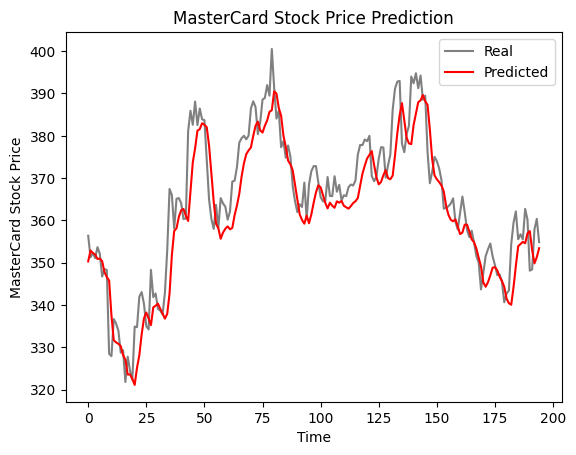

In [ ]:
plot_predictions(test_set,predicted_stock_price)

In [ ]:
#Checking the rms
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 7.06.


# GRU Model

Just replace the LSTM layer with the GRU layer to properly compare the results. The model structure contains a single GRU layer with 125 units and an output layer.

In [ ]:
model_gru = Sequential()
model_gru.add(GRU(units=125, activation="tanh", input_shape=(n_steps, features)))
model_gru.add(Dense(units=1))
# Compiling the RNN
model_gru.compile(optimizer="RMSprop", loss="mse")

model_gru.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 125)               48000     
                                                                 
 dense_1 (Dense)             (None, 1)                 126       
                                                                 
Total params: 48,126
Trainable params: 48,126
Non-trainable params: 0
_________________________________________________________________


The model has successfully trains with 50 epochs and a batch size of 32.

In [ ]:
model_gru.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
38/38 [==============================] - 6s 67ms/step - loss: 0.0168
Epoch 2/50
38/38 [==============================] - 2s 54ms/step - loss: 0.0016
Epoch 3/50
38/38 [==============================] - 4s 105ms/step - loss: 0.0015
Epoch 4/50
38/38 [==============================] - 2s 52ms/step - loss: 0.0013
Epoch 5/50
38/38 [==============================] - 3s 77ms/step - loss: 9.5411e-04
Epoch 6/50
38/38 [==============================] - 3s 74ms/step - loss: 0.0011
Epoch 7/50
38/38 [==============================] - 2s 55ms/step - loss: 6.8110e-04
Epoch 8/50
38/38 [==============================] - 2s 53ms/step - loss: 8.8163e-04
Epoch 9/50
38/38 [==============================] - 2s 53ms/step - loss: 7.2900e-04
Epoch 10/50
38/38 [==============================] - 2s 52ms/step - loss: 8.0931e-04
Epoch 11/50
38/38 [==============================] - 3s 66ms/step - loss: 6.7409e-04
Epoch 12/50
38/38 [==============================] - 3s 85ms/step - loss: 6.3691e-04
Epoch 13

## Results

7/7 [==============================] - 1s 16ms/step


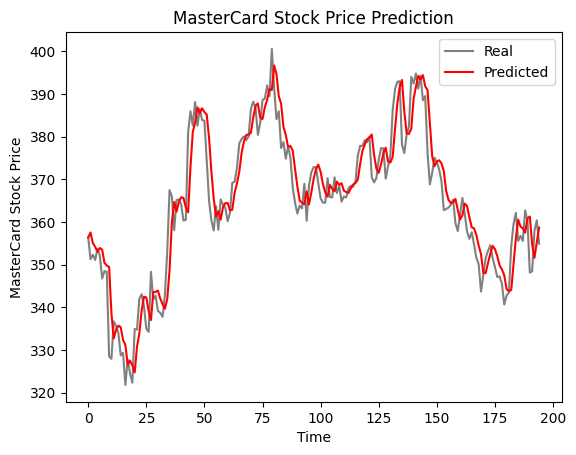

In [ ]:
GRU_predicted_stock_price = model_gru.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)
plot_predictions(test_set, GRU_predicted_stock_price)

We see that the real and predicted values are relatively close. The predicted line chart almost fits the actual values.

In [ ]:
#Checking the rms
return_rmse(test_set,GRU_predicted_stock_price)

The root mean squared error is 5.93.
